In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
from scipy.spatial import Delaunay
import sys
import os
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm

In [339]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF):
        self.interpF = CloughTocher2DInterpolator(points,vals)
        self.inInDomainF = isInDomainF
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
def addInterpF2Data(data):
    valSliceE = slice(0,3)
    valSliceD = slice(0,2)

    data['isInDomainF'] = IsInDomain(data['nodesCurves'])
    data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'])
    data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'])

    data['solutionB'] = []
    data['interpBS'] = []
    data['interpBN'] = []
    data['interpBC'] = []
    for i in range(len(data['idxCurves'])):
        data['solutionB'].append(data['solution'][data['idxCurves'][i]])
        data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
        data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
        data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))

def loadData(filePath):
    with open(filePath, 'r') as f:
        data = json.load(f)
    
    keys_single = ['nodes', 'elements', 'solution', 'elementsBoundaryNodesOnly','areaElementsBoundaryNodesOnly']
    for i in tqdm(range(len(data))):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
        addInterpF2Data(data[i])
    return data

def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def GenerateTriangTrainMeshInter():
    # Generates random variation of a mesh made out of 6 triangular elements in a hexagon configuration
    # The mesh is normalized so that the longest edge length is 1
    #   nodes - [7,2] tensor which containes the x,y positions of nodes of the mesh
    #   elements - [6,3] tensor which containes the indices of the nodes of the mesh

    # constructu a hexagon with a point in the middle
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3 + np.random.uniform(-np.pi/15,np.pi/15,6)
    r = np.random.uniform(0.7,1,6)
    bNodes = np.stack([np.cos(alphas)*r,np.sin(alphas)*r],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)

    # construct element matrix
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1

    # randomly rotate the mesh
    rot = np.random.uniform(0,np.pi/3)
    rot_mat = np.array([[np.cos(rot),np.sin(rot)],[-np.sin(rot),np.cos(rot)]])
    nodes = (rot_mat@nodes.T).T
    return nodes,elements

def RandomTriangSample(nodes):
    # Sample a random points inside a trinagle defined by [3,2] matrix: nodes
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements,Area):
    # Sample a random point from a 2D shape defined with a mesh: (nodes, elements)
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area.flatten()/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

def GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,elSizeMin=0.04,elSizeMax=0.07):
    # Get a random interior training patch mesh from a mesh defined by (nodes, elements, boundaryNodes)
    # The mesh will be scaled so that the longest edge is approximately between elSizeMin and elSizeMax
    # In case the randomly sampled point is so close to the boundary that the Training Patch mesh does not fit fully inside the domain the point is resampled
    iterations = 0
    while (iterations < 1_000):
        samplePoint = RandomMeshSample(nodes,elements,areaElements)
        notesTP, elementsTP = GenerateTriangTrainMeshInter()
        nodesTP = notesTP * np.random.uniform(elSizeMin, elSizeMax) + samplePoint.reshape(1,2)
        isInDomain = isInDomainF(nodesTP)
        if np.all(isInDomain):
            break
        iterations += 1
    return nodesTP, elementsTP

# Defined the points of the encoder input mask
def GetRadialEncoderInputMask(n_r,n_theta,k=0.5,Esize=0.05):
    # Get Radial interior encoder input mask
    #   n_theta - number of radial directions along which points are defined
    #   n_r - number of points along each radial direction
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - size of the interour encoder mask, radius of the circle
    alphas = np.linspace(0,2*np.pi,n_theta+1)[:-1].reshape(1,-1)
    r = np.linspace(0,1,n_r+1)[1:].reshape(-1,1)
    r = k*r+(1-k)*r**3
    nodesIE = np.stack([r*np.cos(alphas),r*np.sin(alphas)],axis=-1)
    nodesIE = np.concatenate([[[0,0]],nodesIE.reshape(-1,2)],axis=0)
    return nodesIE*Esize

def GetSquareEncoderInputMask(n,k=0.5,Esize=0.05):
    # Get Square interior encoder input mask
    #   The mask is a 2n x 2n grid points of size 2*Esize x 2*Esize (in x,y coordinates)
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    x = np.linspace(-1,1,2*n+1)
    x = k*x+(1-k)*x**3
    X,Y = np.meshgrid(x,x)
    nodesIE = np.stack([X,Y],axis=-1).reshape(-1,2)
    return nodesIE*Esize

def GetBoundaryEncoderInputMask(n,k,Esize=0.05):
    # Get boundary encoder input mask whcih is defined along the boundary
    #   total number of points in teh boundary encoder input mask is 2*n-1
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - the size of the  boundary encoder input mask, the length of the mask is 2*Esize
    x = np.linspace(-1,1,2*n-1)
    x = (k*np.abs(x)+(1-k)*np.abs(x)**2) * np.sign(x)
    return x*Esize

def GetEncoderInputTP(nodesTP,nodesIE):
    # Based on training patch mesh nodes (nodesTP) and nodes of the interior encoder input mask (nodesIE) generates all interior encoder input mask points within the training patch
    nodesTP = nodesTP.reshape(-1,1,2)
    nodesIE = nodesIE.reshape(1,-1,2)
    nodesTP_IE = nodesTP + nodesIE
    return nodesTP_IE

def GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False):
    # Samples a random training patch from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   nodesD - decoder output mask nodes
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodes = data[idx]['nodes']
    elements = data[idx]['elementsBoundaryNodesOnly']
    areaElements = data[idx]['areaElementsBoundaryNodesOnly']
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    isInDomainF = data[idx]['isInDomainF']

    nodesTP, elementsTP = GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,elSizeMin,elSizeMax) # get training patch mesh
    nodesTP_IE = GetEncoderInputTP(nodesTP,nodesIE) # get all nodes of the training patch
    uTP_IE = interpSE(nodesTP_IE.reshape(-1,2)).reshape(7,nodesIE.shape[0],-1) # sample solution at training patch nodes
    bTP_IE = isInDomainF(nodesTP_IE.reshape(-1,2)).reshape(7,nodesIE.shape[0]) # sample boundary mask for interior econder input (1 if inside the domain, 0 if outside)
    uTP_IE[~bTP_IE] = 0 # set solution values outside of the domain to 0

    nodesTP_D = nodesD+nodesTP[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        return nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, nodesTP_IE
    else:
        return nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GenerateTriangTrainMeshBoundary(v_rand = 0.1):
    # Generates a mesh of 6 triangular elements in a hexagon configuration where the two bottom points have x,y coordinates (0,0) and (1,0)
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3
    bNodes = np.stack([np.cos(alphas),np.sin(alphas)],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)
    # randomly perturb the nodes except the two bottom ones
    v_rand_nodes = np.random.uniform(-v_rand,v_rand,(7,2))
    v_rand_nodes[[1,2],:] = 0
    nodes += v_rand_nodes
    nodes = nodes-nodes[1]
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    return nodes,elements

def GetRandomTPmeshBoundary(nodesB,length,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,idx_curve_0=None,distance_0=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

    if idx_curve_0 is None:
        length = np.array(length)
        idx_curve_0 = np.random.choice(np.arange(len(nodesB)),p=length/length.sum())
        # idx_curve_0 = np.random.randint(0,len(nodesB))
    if distance_0 is None:
        distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

    iterations = 0
    while iterations < 1_000:

        elSize = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh
        distance_1 = (distance_0 + elSize)%length[idx_curve_0] # define the second point of the training patch mesh on the boundary

        # interpolate the boundary nodes between the two sampled points
        nodes_0 = interpNodesB[idx_curve_0](distance_0)
        nodes_1 = interpNodesB[idx_curve_0](distance_1)

        # Computes the appropriate scaling and rotation for the normalized training patch mesh
        rotTPB = -np.arctan2(nodes_1[1]-nodes_0[1],nodes_1[0]-nodes_0[0])
        elSizeTPB = np.sqrt(((nodes_1 - nodes_0)**2).sum())
        rot_mat = np.array([[np.cos(rotTPB),np.sin(rotTPB)],[-np.sin(rotTPB),np.cos(rotTPB)]])
        nodesTPB, elementsTPB = GenerateTriangTrainMeshBoundary()
        nodesTPB = (rot_mat@nodesTPB.T).T * elSizeTPB + nodes_0
        isInDomain = IsInDomainF(nodesTPB[[0,3,4,5,6]])
        # break
        if np.all(isInDomain):
            break
        iterations += 1
        distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

    # print(iterations)
    return nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0

def GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodesB = data[idx]['nodesCurves']
    lengthCurves = data[idx]['lengthCurves']
    interpNodesB = data[idx]['interpBC']
    isInDomainF = data[idx]['isInDomainF']

    # Get random training patch mesh
    nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0 = GetRandomTPmeshBoundary(nodesB,lengthCurves,interpNodesB,isInDomainF,elSizeMin,elSizeMax)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve_0]
    interpBN = data[idx]['interpBN'][idx_curve_0]

    nodesTP_BEi = GetEncoderInputTP(nodesTPB[[0,3,4,5,6]],nodesIE) # get nodes for the interour encoder input
    uTP_BEi = interpSE(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1],-1)
    bTP_BEi = isInDomainF(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1])
    uTP_BEi[~bTP_BEi] = 0
    distanceTP_BEb = np.array([[distance_0],[distance_1]])+distanceBE # get alpha for the boundary encoder input
    uTP_BEb = interpBS(distanceTP_BEb)
    normalTP_BEb = interpBN(distanceTP_BEb)

    nodesTP_D = nodesD+nodesTPB[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve_0]
        nodesTP_BEb = interpBC(distanceTP_BEb)
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb
    else:
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    for i in range(batch_size*n_batches):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        nodesTP = tf.convert_to_tensor(nodesTP, dtype=tf.float32)
        elementsTP = tf.convert_to_tensor(elementsTP, dtype=tf.int32)
        uTP_IE = tf.convert_to_tensor(uTP_IE, dtype=tf.float32)
        bTP_IE = tf.convert_to_tensor(bTP_IE, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GetInteriorDataset(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_D = data[0]['interpD'].nDims
    dataset = tf.data.Dataset.from_generator(
        lambda: InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([7,nodesIE.shape[0],d_IE]), tf.TensorShape([7,nodesIE.shape[0],1]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetInteriorDatasetFixed(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_D = data[0]['interpD'].nDims
    InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
    dataset_tesor_nodesTP = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTP = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        dataset_tesor_nodesTP[i] = nodesTP
        dataset_tesor_elementsTP[i] = elementsTP
        dataset_tesor_uTP_IE[i] = uTP_IE
        dataset_tesor_bTP_IE[i] = bTP_IE
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D
    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTP, dataset_tesor_elementsTP, 
                                                  dataset_tesor_uTP_IE, dataset_tesor_bTP_IE, 
                                                  dataset_tesor_u_D, dataset_tesor_b_D))

    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def BoundaryDatasetGenerator(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    for i in range(batch_size*n_batches):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, s_alphaBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
        nodesTPB = tf.convert_to_tensor(nodesTPB, dtype=tf.float32)
        elementsTPB = tf.convert_to_tensor(elementsTPB, dtype=tf.int32)
        uTP_BEi = tf.convert_to_tensor(uTP_BEi, dtype=tf.float32)
        bTP_BEi = tf.convert_to_tensor(bTP_BEi, dtype=tf.float32)
        uTP_BEb = tf.convert_to_tensor(uTP_BEb, dtype=tf.float32)
        normalTP_BEb = tf.convert_to_tensor(normalTP_BEb, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def GetBoundaryDataset(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_BE = data[0]['interpB'].c.shape[-1]
    d_D = data[0]['interpD'].nDims
    dataset = tf.data.Dataset.from_generator(
        lambda: BoundaryDatasetGenerator(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMin),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([5,nodesIE.shape[0],d_IE]), tf.TensorShape([5,nodesIE.shape[0],1]), 
                       tf.TensorShape([2,s_alphaBE.shape[0],d_BE]), tf.TensorShape([2,s_alphaBE.shape[0],2]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetBoundaryDatasetFixed(data, nodesIE, s_alphaBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interp'].nDims
    d_BE = data[0]['interpB'].c.shape[-1]
    d_D = data[0]['interpD'].nDims

    dataset_tesor_nodesTPB = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTPB = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_uTP_BEb = np.zeros((batch_size*n_batches, 2, s_alphaBE.shape[0], d_BE),dtype=np.float32)
    dataset_tesor_normalTP_BEb = np.zeros((batch_size*n_batches, 2, s_alphaBE.shape[0], 2),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, s_alphaBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMin)
        dataset_tesor_nodesTPB[i] = nodesTPB
        dataset_tesor_elementsTPB[i] = elementsTPB
        dataset_tesor_uTP_BEi[i] = uTP_BEi
        dataset_tesor_bTP_BEi[i] = bTP_BEi
        dataset_tesor_uTP_BEb[i] = uTP_BEb
        dataset_tesor_normalTP_BEb[i] = normalTP_BEb
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D

    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTPB, dataset_tesor_elementsTPB,
                                                    dataset_tesor_uTP_BEi, dataset_tesor_bTP_BEi,
                                                    dataset_tesor_uTP_BEb, dataset_tesor_normalTP_BEb,
                                                    dataset_tesor_u_D, dataset_tesor_b_D))
    
    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [5]:
filePath = 'TrainingData/LowReFlowDataProcessed/dataLowReFLow.json'

data_arr = loadData(filePath)

100%|██████████| 3973/3973 [01:15<00:00, 52.28it/s]


In [254]:
data = data_arr[100]
nodes = data['nodes']
elements = data['elementsBoundaryNodesOnly']
areaElements = data['areaElementsBoundaryNodesOnly']
isInDomainF = data['isInDomainF']

n_TP = 300
nodesTP_arr = np.zeros((n_TP,7,2))
elementsTP_arr = np.zeros((n_TP,6,3))
for i in range(n_TP):
    nodesTP_arr[i], elementsTP_arr[i] = GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,elSizeMin=0.1,elSizeMax=0.2)

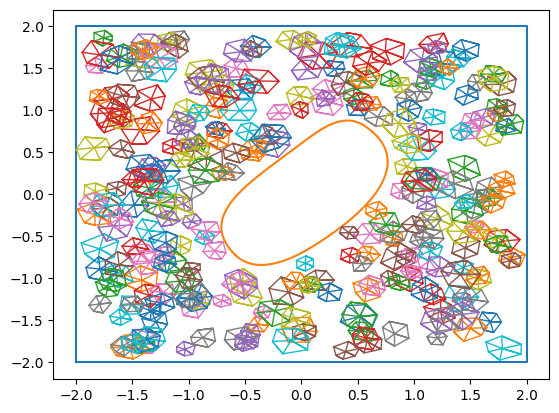

In [22]:
nodesCurves = data['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

idx_mesh = [6,1,2,3,4,5,6,0,1,2,0,3,0,4,5,0]
for i in range(n_TP):
    plt.plot(nodesTP_arr[i,idx_mesh,0],nodesTP_arr[i,idx_mesh,1],linewidth=1)

In [256]:
data = data_arr[100:101]
nodesIE = GetRadialEncoderInputMask(5,8,0.7,0.3)
nodesD = GetRadialEncoderInputMask(0,0)
elSizeMin = 0.2
elSizeMax = 0.21
debugging = True

while True:
    nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, nodesTP_IE = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin, elSizeMax, debugging)
    if np.any(~bTP_IE):
        break

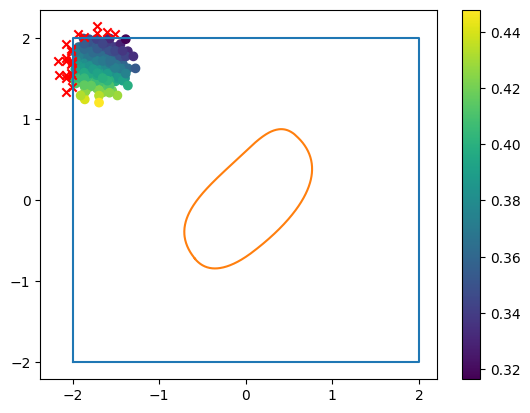

In [257]:
nodesCurves = data[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

nodes_in = nodesTP_IE[bTP_IE]
nodes_out = nodesTP_IE[~bTP_IE]
u_in = uTP_IE[bTP_IE]
u_out = uTP_IE[~bTP_IE]
plt.scatter(nodes_in[:,0],nodes_in[:,1],c=u_in[:,2])
plt.colorbar()
plt.scatter(nodes_out[:,0],nodes_out[:,1],c='r', marker='x')

In [162]:
data = data_arr[100]
nodesB = data['nodesCurves']
distance = data['distanceCurves']
length = data['lengthCurves']
interpNodesB = data['interpBC']
isInDomainF = data['isInDomainF']
elSizeMin=0.1
elSizeMax=0.11
idx_curve_0=None
distance_0=None

n_TPB = 200
nodesTPB_arr = np.zeros((n_TPB,7,2))
elementsTPB_arr = np.zeros((n_TPB,6,3))
for i in range(n_TPB):
    nodesTPB_arr[i], elementsTPB_arr[i],_,_,_ = GetRandomTPmeshBoundary(nodesB,length,interpNodesB,isInDomainF,elSizeMin=0.1,elSizeMax=0.2)

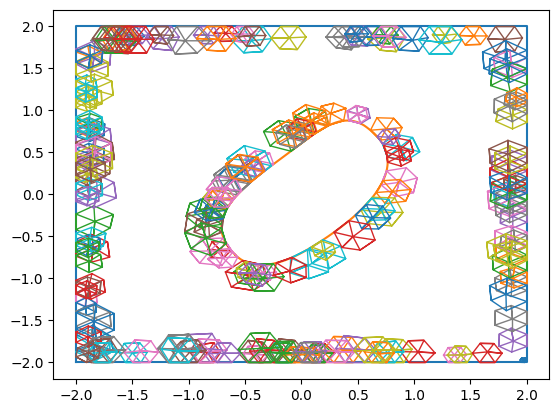

In [163]:
nodesCurves = data['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

idx_mesh = [6,1,2,3,4,5,6,0,1,2,0,3,0,4,5,0]
# plt.plot(nodesTPB[idx_mesh,0],nodesTPB[idx_mesh,1],linewidth=1)
for i in range(n_TPB):
    plt.plot(nodesTPB_arr[i,idx_mesh,0],nodesTPB_arr[i,idx_mesh,1],linewidth=1)

# plt.xlim(1,2.1)
# plt.ylim(1,2.1)

In [330]:
def GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodesB = data[idx]['nodesCurves']
    lengthCurves = data[idx]['lengthCurves']
    interpNodesB = data[idx]['interpBC']
    isInDomainF = data[idx]['isInDomainF']

    # Get random training patch mesh
    nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0 = GetRandomTPmeshBoundary(nodesB,lengthCurves,interpNodesB,isInDomainF,elSizeMin,elSizeMax)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve_0]
    interpBN = data[idx]['interpBN'][idx_curve_0]

    nodesTP_BEi = GetEncoderInputTP(nodesTPB[[0,3,4,5,6]],nodesIE) # get nodes for the interour encoder input
    uTP_BEi = interpSE(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1],-1)
    bTP_BEi = isInDomainF(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1])
    uTP_BEi[~bTP_BEi] = 0
    distanceTP_BEb = np.array([[distance_0],[distance_1]])+distanceBE # get alpha for the boundary encoder input
    uTP_BEb = interpBS(distanceTP_BEb)
    normalTP_BEb = interpBN(distanceTP_BEb)

    nodesTP_D = nodesD+nodesTPB[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve_0]
        nodesTP_BEb = interpBC(distanceTP_BEb)
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb
    else:
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D
    
data = data_arr[100:101]
nodesIE = GetRadialEncoderInputMask(5,8,0.7,0.3)
nodesD = GetRadialEncoderInputMask(0,0)
distanceBE = GetBoundaryEncoderInputMask(8,0.7,0.6)
elSizeMin = 0.2
elSizeMax = 0.21
debugging = True

nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb = GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin, elSizeMax, debugging)


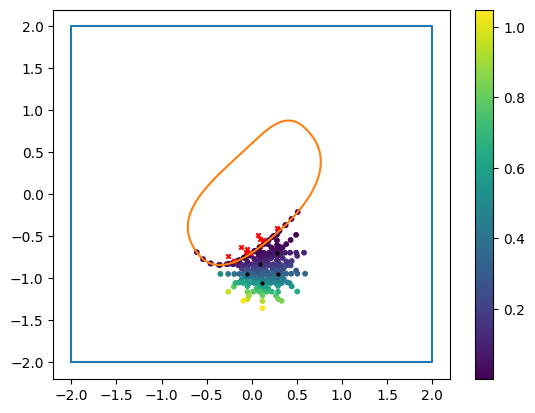

In [338]:
nodesCurves = data[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

nodes_in = nodesTP_BEi[bTP_BEi]
nodes_out = nodesTP_BEi[~bTP_BEi]
u_in = uTP_BEi[bTP_BEi]
u_out = uTP_BEi[~bTP_BEi]
x = np.concatenate([nodes_in[:,0],nodesTP_BEb[:,:,0].flatten()])
y = np.concatenate([nodes_in[:,1],nodesTP_BEb[:,:,1].flatten()])
u = np.concatenate([u_in[:,:],uTP_BEb[:,:,:].reshape(-1,3)],0)

# plt.scatter(nodes_in[:,0],nodes_in[:,1],c=u_in[:,2])
# plt.colorbar()
# plt.scatter(nodesTP_BEb[:,:,0].flatten(),nodesTP_BEb[:,:,1].flatten(),c=uTP_BEb[:,:,0])
plt.scatter(x,y,c=u[:,0],s=10)
plt.colorbar()
plt.scatter(nodes_out[:,0],nodes_out[:,1],c='r', marker='x',s=10)
plt.scatter(nodesTPB[:,0],nodesTPB[:,1],c='k',s=4)

In [281]:
data = data_arr[0]

nodesMesh = np.concatenate(data['nodesCurves'])
n_edges = np.cumsum([len(curve) for curve in (data['nodesCurves'])])
tri = Delaunay(nodesMesh)
triangles = tri.simplices

for i in range(data['nodesCurves']):
    idx_pick = np.logical_and(triangles>6,triangles<1000).all(1)

plt.triplot(nodesMesh[:,0], nodesMesh[:,1], tri.simplices)

TypeError: 'list' object cannot be interpreted as an integer